# Forecasting With Classical and Machine Learning Methods Using sktime

This presentation is designed to develop a framework for building useful forecasting models using both traditional forecasting techniques, as well as more contemporary machine learning approaches.  

Both techniques have strengths and drawbacks, and we want to learn how and when we might be able to use one or both.

We also want to learn about sktime, a powerfull all-in-one tool for time series analysis that enables use of both.

### What Is Forecasting?

Forecasting is the process of making predictions about future events or trends by analyzing past and present data.

Forecasts are built by studying time series data.

What is time series data?

time series = recorded observations of one object or process at different time points.

observations at different time points are of same kind/type.

observations recorded with time index (= recorded time stamp)

In [1]:
import warnings
warnings.filterwarnings("ignore")
from sktime.datasets import load_airline

y = load_airline()
y

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

What makes time series problems unique?  

The biggest difference between time series data and non-time series data is the presence of auto-correlation.  

In time series data, one observation is commonly influenced by a previous value, which violates the assumption that your data is independent and identically distributed.

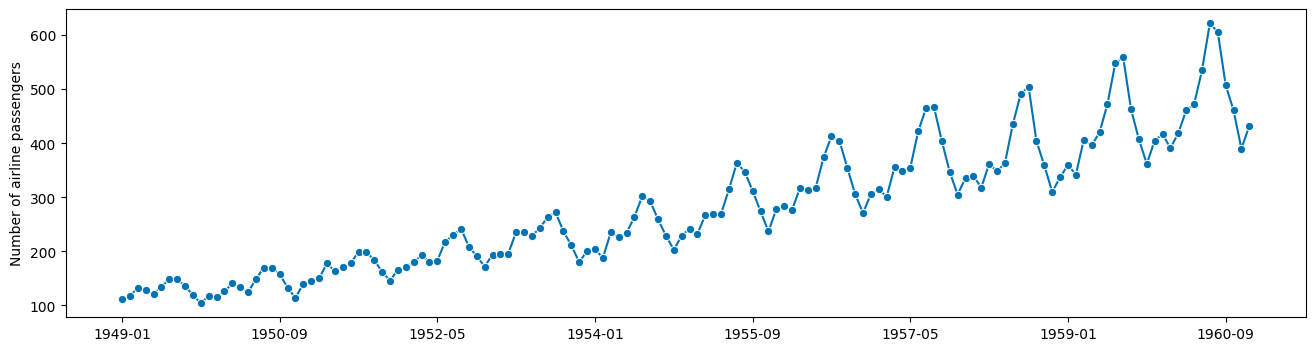

In [2]:
# airlines data
from sktime.utils.plotting import plot_series

fig, ax = plot_series(y)

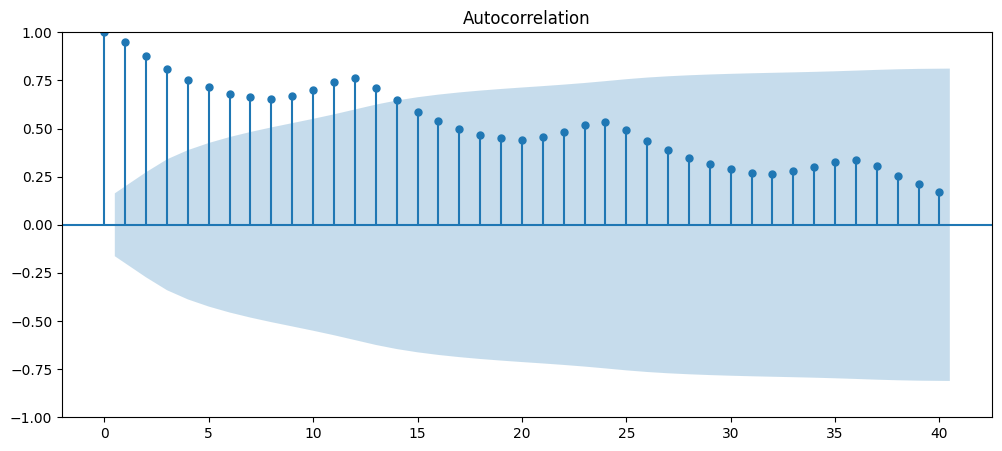

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

sm.graphics.tsa.plot_acf(y, lags=40, ax = ax)
plt.show()

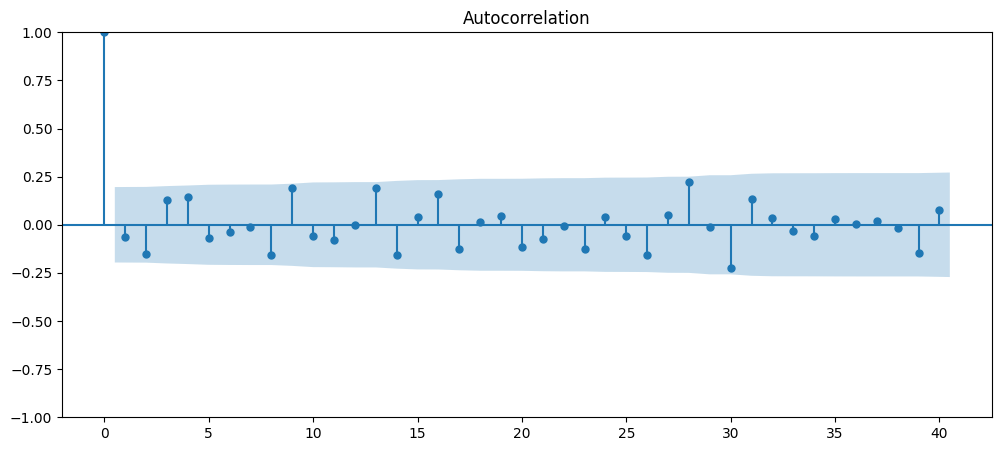

In [4]:
# for comparison, here's what this plot would look like for completely random data
import numpy as np

random_data = np.random.normal(0, 1, size = 100)

fig, ax = plt.subplots(figsize=(12, 5))

sm.graphics.tsa.plot_acf(random_data, lags=40, ax = ax)
plt.show()

Statistical learning models are typically built on the assumption that your data is i.i.d.  

Time series models are built to accommodate the statistical structure of temporally dependent data by accounting for trend and auto-correlation.  

Common examples of time series models include:  Exponential Smoothing, ARIMA, Theta, etc.  

Using time series models for forecasting problems has been standard up until the current day.  Even with advances in machine learning, ML models with large parameters frequently underperform classical time series methods.  

Case in point:  the Monash Forecasting Repository.  https://forecastingdata.org/

It's a collection of 30 datasets to be used for time series benchmarks.  Even today, classical time series methods still regularly outperform the latest deep learning models on a number of datasets.

![Monash Forecasting Results](../images/monash_respository.png)

However, there are compelling reasons to want to use ML for forecasting problems.  

 - Ability to recognize non-linear patterns
 - Ability to incorporate large amounts of non-time based exogenous data
 - Ability to capture global patterns among many time series
 - Recent successes using ML in forecasting competitions

![MOFC Center](../images/mofc_logo.png)  

**Case in point:**  The "M" competitions held by the Makridakis Open Forecasting Center.

**To do:** Add more information about the different competitions and background information about the best participants.  Will follow up with later.

Operationally, using ML for forecasting problems presents some issues.

Data has to undergo additional pre-processing to make it suitable for forecasting.  

ML models don't naturally produce a forecast horizon like some time series models do.   

Sktime provides appealing solutions to these problems, and makes it easy to easily switch between classical time series models and machine learning techniques. 
![sktime](../images/unified_framework.png)

There are **many** choices for time series tools in the python ecosystem, but **practically none** for making them work together harmoniously.  Sktime provides an easy, flexible interface for working through time series problems from beginning to end.

Concerning using machine learning and forecasting.....

ML models don't have an innate ability to "see" previous samples in the data.  

![tabularization](../images/tabularization.png)

The following code will recreate the above diagram and fit it to a histogram based gradient boosting model.

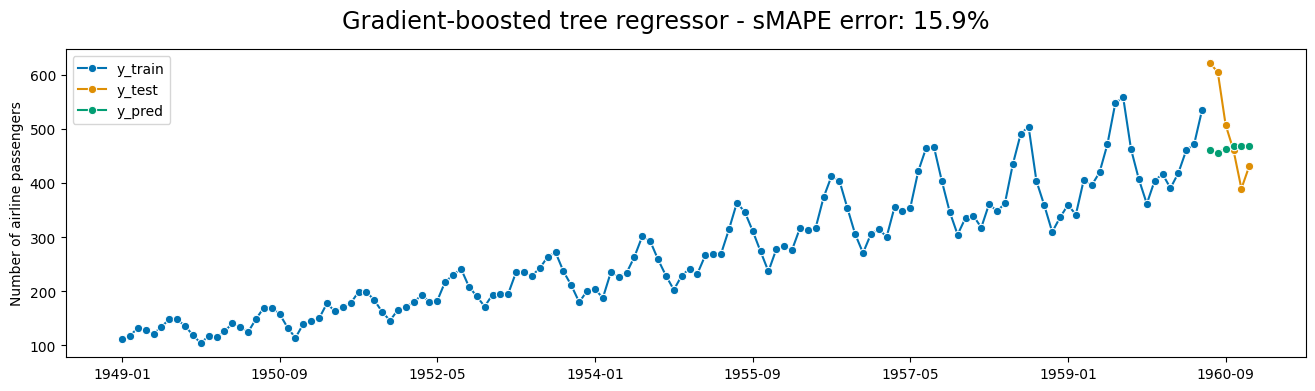

In [5]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

y_train, y_test = temporal_train_test_split(y=y, test_size=6)

fh = [1, 2, 3, 4, 5, 6]

# Can be swapped with XBGoost, LightGBM, CatBoost, etc.
regressor = HistGradientBoostingRegressor()

# Create a forecaster from the tabular regressor by wrapping it in `make_reduction`
forecaster = make_reduction(regressor, strategy="direct", window_length=16)

y_pred = forecaster.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

In the above code, the `regressor` algorithm can be swapped out with any other algorithm that has a `fit` and `predict` method.  

The `make_reduction` function automatically does performs the pre-processing step of transforming previous values into exogenuous variables.

However, a quick eyeball test reveals these predictions to be very unsatisfactory.  

It also does not outperform an AutoARIMA model out of the box.

In [6]:
from sktime.forecasting.arima import AutoARIMA

arima_forecaster = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)
y_pred_arima = arima_forecaster.fit_predict(y=y_train, fh=fh)

print(f"Gradient-boosted tree regressor - sMAPE error: {smape(y_test, y_pred):.1%}")
print(f"AutoARIMA - sMAPE error: {smape(y_test, y_pred_arima):.1%}")

Gradient-boosted tree regressor - sMAPE error: 15.9%
AutoARIMA - sMAPE error: 2.2%


Why is the GBM under-performing?:

- Gradient boosting trees cannot "extrapolate"
- only forecast well within their observed range

Solution: make (more) stationary by differencing

easy to do in `sktime`: transformers (= transformation estimators)

(note: wider concept than deep learn transformers, includes simple trafos too)

Let's see how to use the `Differencer` transformer:

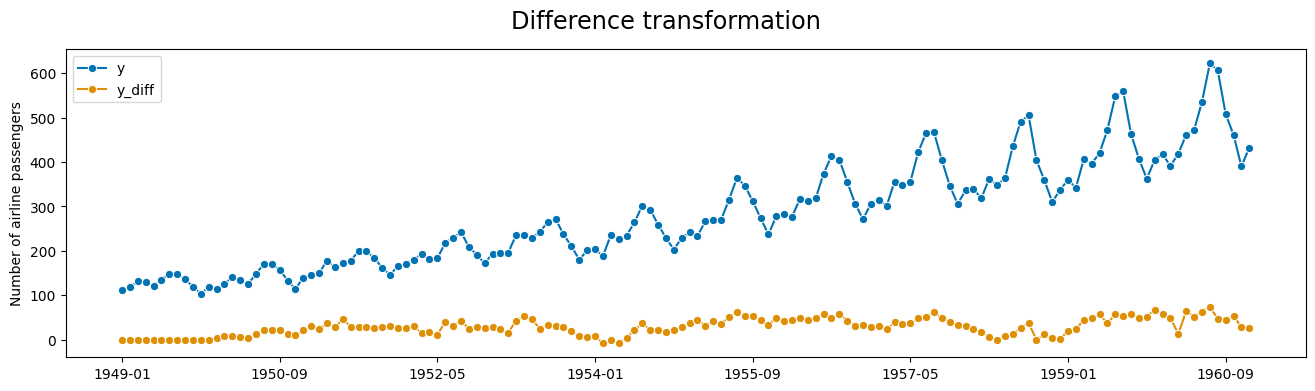

In [7]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer(lags=12)
y_transform = transformer.fit_transform(y)
fig, ax = plot_series(
    y, y_transform, labels=["y", "y_diff"], title="Difference transformation"
)

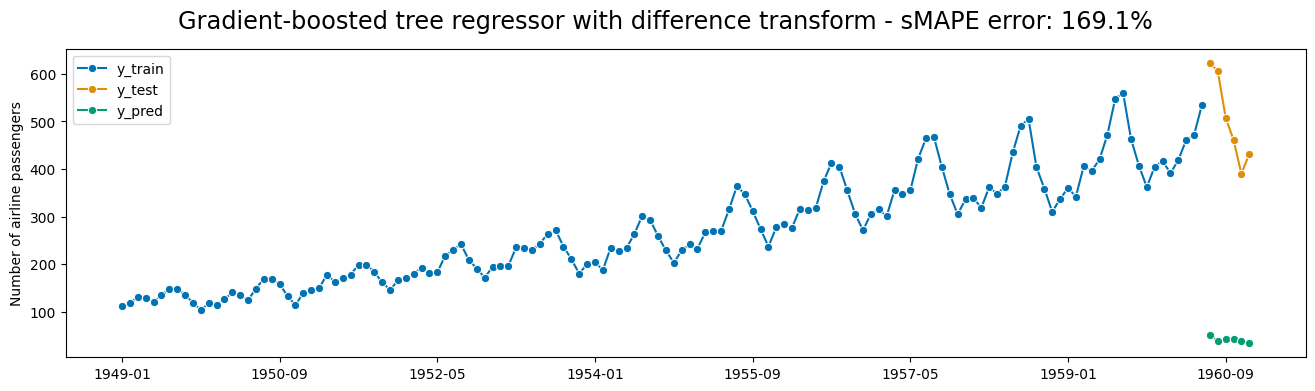

In [8]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=16)
forecaster_with_differencer = Differencer(lags=12) * forecaster

# to do:  use transformed target forecaster for this step
y_pred = forecaster_with_differencer.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor with difference transform - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

We would like to take this example extend it to account for more complicated scenarios:  

 - Forecasting many time series simultaneously, many of which may be interrelated.
 - Producing features beyond using lag values

### Panel Forecasting With ML and sktime

The examples so far have focused on a single time series.

However, most real world problems often involve multiple time series, many of which exist in a hierarchy.

![hierarchical time series](../images/hierarchy.png)

In [9]:
# example hierarchical time series
from pydata_utils import load_product_hierarchy

y = load_product_hierarchy()

y

Sales
Product line      Product group Date          
Food preparation  Hobs          2000-01  245.0
                                2000-02  144.0
                                2000-03  184.0
                                2000-04  265.0
                                2000-05  236.0
...                                        ...
Food preservation Fridges       2004-08  176.0
                                2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0

[240 rows x 1 columns]

A key component of hierarchical time series is that many of the individual time series are related to one another. 

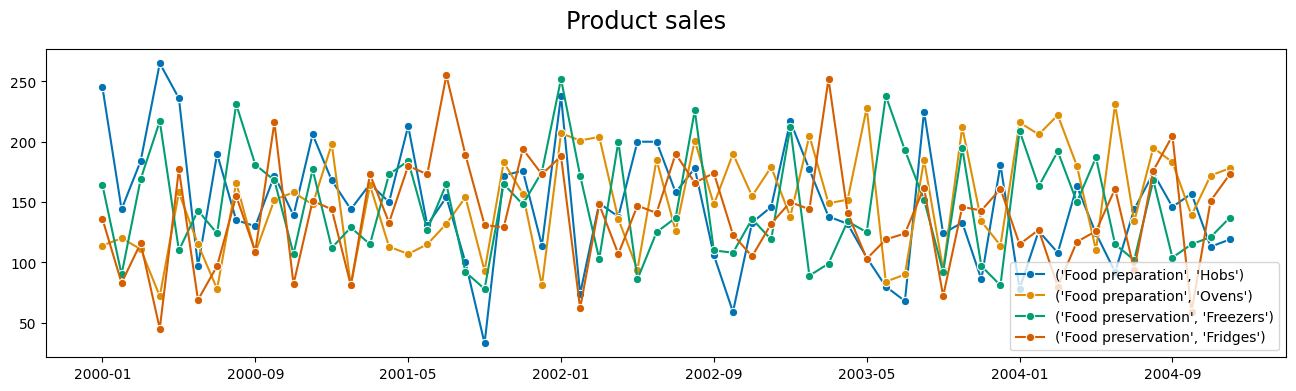

In [10]:
product_index = y.droplevel(-1).index.unique()
fig, ax = plot_series(*(y.loc[idx] for idx in product_index), labels=product_index, title="Product sales")

Traditionally, each individual time series would be modeled separately.  

This approach potentially misses the shared properties of the different time series, making their modeling inefficient.  

For ML models, a better approach is often to fit all of the time series jointly.

Simultaneously fitting many time series is known as global forecasting, and is the approach that's been successfully used to win forecasting competitions.  

**To Do:** Add in a fact or reference about M5 competition here.

Using global approaches to model many time series is straight forward in sktime.

In [13]:
# create the train and test sets
y_train, y_test = temporal_train_test_split(y, test_size=4)

# to do:  add in differencing w/ transformed targetforecaster
regressor         = HistGradientBoostingRegressor()
forecaster_local  = make_reduction(regressor, strategy="direct", window_length=12, pooling="local")
forecaster_global = make_reduction(regressor, strategy="direct", window_length=12, pooling="global")
forecaster_arima  = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)

hier_smape = MeanAbsolutePercentageError(symmetric=True, multilevel="raw_values")

y_pred_local = forecaster_local.fit_predict(y_train, fh=[1, 2, 3, 4])
y_pred_global = forecaster_global.fit_predict(y_train, fh=[1, 2, 3, 4])
y_pred_arima = forecaster_arima.fit_predict(y_train, fh = [1, 2, 3, 4])

errors_local = hier_smape(y_test, y_pred_local)
errors_global = hier_smape(y_test, y_pred_global)
errors_arima = hier_smape(y_test, y_pred_arima)

print(f"Average sMAPE with local pooling: {errors_local.mean().iloc[0]:.1%}")
print(f"Average sMAPE with global pooling: {errors_global.mean().iloc[0]:.1%}")
print(f"Average sMAPE with AutoARIMA: {errors_arima.mean().iloc[0]:.1%}")

Average sMAPE with local pooling: 27.5%
Average sMAPE with global pooling: 22.9%
Average sMAPE with AutoARIMA: 21.7%


### Feature Engineering

Machine learning models can benefit from feature engineering that captures different aspects of a time series, such as its summary statistics and distributional characteristics.  

Producing these features can easily be added in to sktime pipelines.

For example, window statistics are often helpful for capturing local trends in your data that make it easier for models to detect changes in the data generating process behind your forecasts.

In [43]:
from sktime.transformations.series.summarize import WindowSummarizer

# arguments for the window transformer
kwargs = {
    "lag_feature": {
        "lag": [1, 2, 3],
        "mean": [[1, 3]],
        "std": [[1, 10]],
        "kurt": [[1, 10]]},
    "truncate": 'bfill'
}

summarizer = WindowSummarizer(**kwargs, n_jobs = 1)
window_data = summarizer.fit_transform(y_train)
window_data

Sales_lag_1  Sales_lag_2  \
Product line      Product group Date                                
Food preparation  Hobs          2000-01        245.0        245.0   
                                2000-02        245.0        245.0   
                                2000-03        144.0        245.0   
                                2000-04        184.0        144.0   
                                2000-05        265.0        184.0   
...                                              ...          ...   
Food preservation Fridges       2004-04         80.0        127.0   
                                2004-05        117.0         80.0   
                                2004-06        126.0        117.0   
                                2004-07        161.0        126.0   
                                2004-08         94.0        161.0   

                                         Sales_lag_3  Sales_mean_1_3  \
Product line      Product group Date                                   
Food preparation  Hobs          2000-01        245.0      211.333333   
                                2000-02        245.0      211.333333   
                                2000-03        245.0      211.333333   
                                2000-04        245.0      191.000000   
                                2000-05        144.0      197.666667   
...                                              ...             ...   
Food preservation Fridges       2004-04        115.0      107.333333   
                                2004-05        127.0      108.000000   
                                2004-06         80.0      107.666667   
                                2004-07        117.0      134.666667   
                                2004-08        126.0      127.000000   

                                         Sales_std_1_10  Sales_kurt_1_10  
Product line      Product group Date                                      
Food preparation  Hobs          2000-01       58.815059        -1.560127  
                                2000-02       58.815059        -1.560127  
                                2000-03       58.815059        -1.560127  
                                2000-04       58.815059        -1.560127  
                                2000-05       58.815059        -1.560127  
...                                                 ...              ...  
Food preservation Fridges       2004-04       30.559414        -0.384103  
                                2004-05       30.608822        -0.433587  
                                2004-06       30.610274        -0.409658  
                                2004-07       30.476949        -0.403151  
                                2004-08       26.816247        -0.555609  

[224 rows x 6 columns]

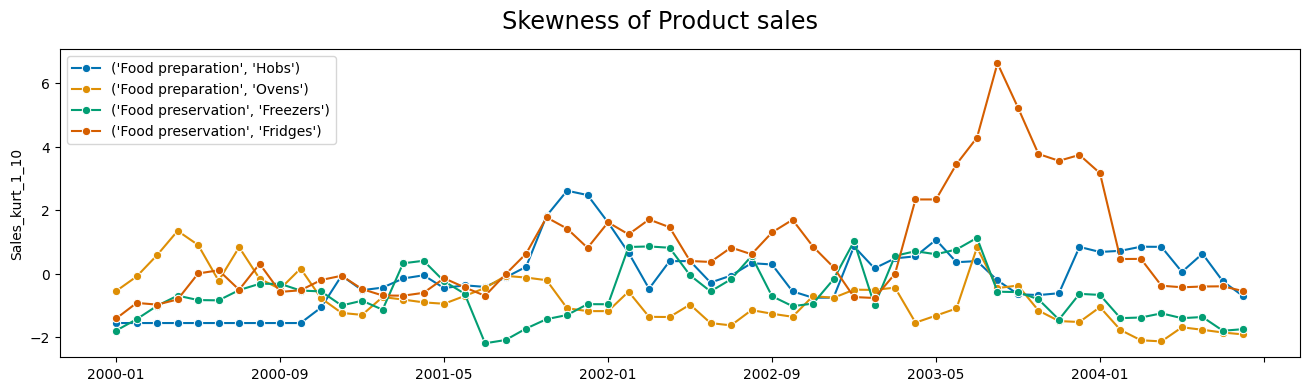

In [45]:
# window statistics can capture local patterns in a time series
# not easily observed by lag values alone
fig, ax = plot_series(*(window_data.loc[idx, 'Sales_kurt_1_10'] for idx in product_index), 
                      labels=product_index, title="Skewness of Product sales")

In [46]:
from sktime.transformations.series.summarize import WindowSummarizer

# arguments for the window transformer
kwargs = {
    "lag_feature": {
        "lag": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "mean": [[1, 3]],
        "std": [[1, 10]],
        "kurt": [[1, 10]]},
    "truncate": 'bfill'
}

forecaster_window = make_reduction(
    regressor,
    transformers=[WindowSummarizer(**kwargs, n_jobs=1)],
    window_length=None,
    strategy="direct",
    pooling="global",
)

y_pred_global_window = forecaster_window.fit_predict(y_train, fh=[1, 2, 3, 4])
errors_global_window = hier_smape(y_test, y_pred_global_window)

print(f"Average sMAPE with local pooling: {errors_local.mean().iloc[0]:.1%}")
print(f"Average sMAPE with global pooling: {errors_global.mean().iloc[0]:.1%}")
print(f"Average sMAPE with AutoARIMA: {errors_arima.mean().iloc[0]:.1%}")
print(f"Average sMAPE with window transformations: {errors_global_window.mean().iloc[0]:.1%}")

Average sMAPE with local pooling: 27.5%
Average sMAPE with global pooling: 22.9%
Average sMAPE with AutoARIMA: 21.7%
Average sMAPE with window transformations: 18.9%


As we can see in the above example, we've now beat the AutoARIMA baseline.  

Global forecasting also has faster fitting times than local forecasting.

In [48]:
%timeit forecaster_window.fit(y_train, fh=[1, 2, 3, 4])
%timeit forecaster_arima.fit(y_train, fh=[1, 2, 3, 4])

338 ms ± 44.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.74 s ± 52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
